<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
RunningInCOLAB

False

In [2]:
if RunningInCOLAB:
    try:
      # %tensorflow_version only exists in Colab.
      %tensorflow_version 2.x
    except Exception:
      pass
else: 
    import tensorflow as tf
    tf_version = tf.__version__
    print(tf_version)

2.3.0


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [5]:
def trend(time, slope=0):
    return slope * time

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
series

array([0.0000000e+00, 1.0000000e-01, 2.0000000e-01, ..., 1.4580000e+02,
       1.4590001e+02, 1.4600000e+02], dtype=float32)

In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [7]:
amplitude = 50
slope = 0.05
noise_level = 10

In [8]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [9]:
series = baseline + trend(time, slope)

In [10]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

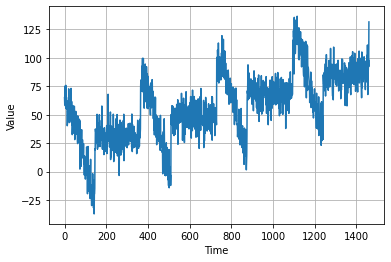

In [11]:
series += noise(time, noise_level, seed=42)
plot_series(time,series)

In [12]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
layer1 = tf.keras.layers.Dense(10, input_shape=[window_size],activation="relu")
layer2 = tf.keras.layers.Dense(10, activation="relu")
output_layer =  tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([layer1,layer2, output_layer])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

#print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


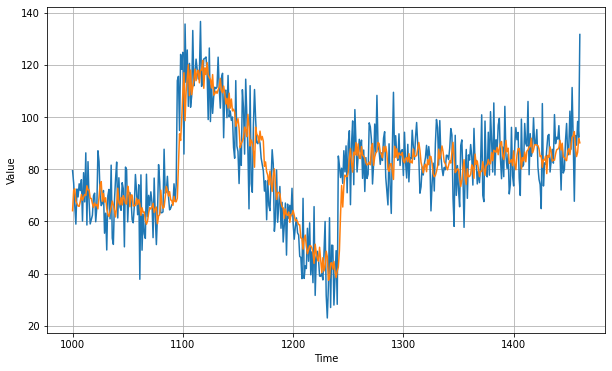

In [16]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

9.089501

In [18]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

138.65407

In [21]:
#reference: https://gist.github.com/zhangruochi/1a8662cca4b73ad745752d660a4a7431
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=100,verbose=0,callbacks=[lr_scheduler])

(1e-08, 0.001, 0.0, 300.0)

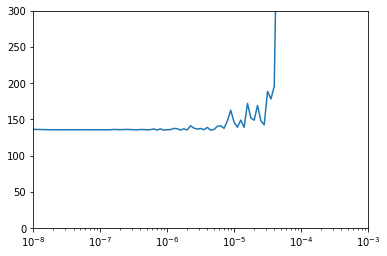

In [22]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

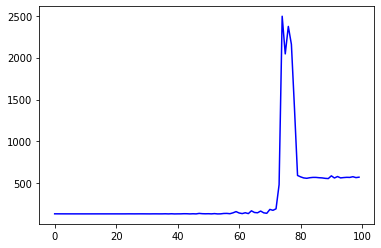

In [34]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs,loss,'b')

In [45]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9))
history = model.fit(dataset,epochs=100,verbose=0)

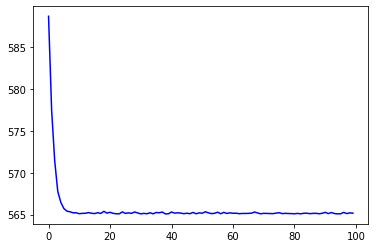

In [46]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs,loss,'b')

In [59]:
lr_array = [1e-4,1e-5,1e-6,8e-6,1e-7,1e-8]
history_array = []
for _lr  in lr_array:
    model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=_lr, momentum=0.9))
    _history = model.fit(dataset,epochs=100,verbose=0)
    _loss = _history.history['loss']
    history_array.append(_loss)

In [60]:
#history_array

Text(0.5, 1.0, 'Loss vs Epochs for various Learning Rates')

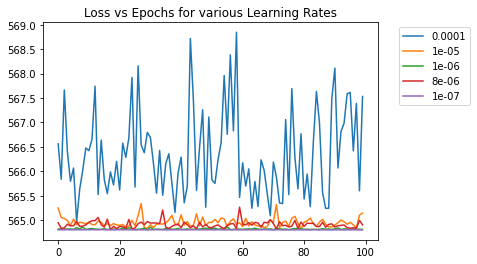

In [64]:
for i in range(0,5):
    plt.plot(epochs,history_array[i],label=lr_array[i])            
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Loss vs Epochs for various Learning Rates')